In [4]:
directory = 'C:\\Data_Competitions\\Facebook image matching\\FB_image_matching_competition\\'
data_directory = directory + 'data\\'
training_image_path = data_directory + 'training_images\\'
ref_image_path = data_directory + 'reference_images\\'
query_image_path = data_directory + 'query_images\\'
ground_truth_csv = directory + 'public_ground_truth.csv'

In [2]:
import os
from timeit import default_timer as timer
from datetime import timedelta
import pandas as pd

In [3]:
import pandas as pd
import numpy as np
def converter(instr):
    return np.fromstring(instr[1:-1],sep=' ')
df_query = pd.read_csv('triplet_loss//query_embedding_semihard48.csv',converters={'embedding':converter})
df_ref = pd.read_csv('triplet_loss//ref_embedding_semihard48.csv',converters={'embedding':converter})

In [4]:
len(df_query)

50000

In [5]:
df_query

,image_id,embedding
0,Q17163,"[-0.0121515431, 0.0157464072, 0.00326675293, 0..."
1,Q20689,"[0.0160125829, 0.0110880081, 0.00545961317, -0..."
2,Q33711,"[0.0198630393, -0.0227208361, -0.00196666014, ..."
3,Q11538,"[0.00724269869, -0.0224623587, -0.00211437419,..."
4,Q04551,"[0.00361533533, -0.00941679254, -0.00150467327..."
...,...,...
49995,Q23423,"[0.00515096681, -0.0112483399, 0.00034877102, ..."
49996,Q18510,"[0.0233375411, -0.024728002, -0.00310620386, -..."
49997,Q14968,"[0.00431012921, -0.0236105025, -0.0054453793, ..."
49998,Q15601,"[0.00968831126, -0.00271568471, 0.00263798283,..."


In [6]:
df_ref = df_ref.rename(columns={0:'image_id',1:'embedding'}).set_index('image_id')
df_query = df_query.rename(columns={0:'image_id',1:'embedding'}).set_index('image_id')
df_ref.sort_index(inplace=True)
df_query.sort_index(inplace=True)

In [7]:
from sklearn.metrics import pairwise_distances
def calculate_distance(df1,df2):
    result = []
    dis_matrix = pairwise_distances(np.stack(df1.iloc[:,0]), np.stack(df2.iloc[:,0]), metric = 'euclidean', n_jobs = 3)
    dis_argmin = dis_matrix.argmin(axis = 1)
    dis_min = np.amin(dis_matrix,axis=1)
    for i in range(len(df1.index.values)):
        index2 = df2.index[dis_argmin[i]]
        index1 = df1.index.values[i]
        result.append((index1, index2, dis_min[i]))
    return result

In [8]:
# Unable to allocate 373. GiB for an array with shape (50000, 1000000) with data type float64 (That's the memory cost for calculate pairwise_distance for the full entire embedding matrixes pair), so had to chunk streaming it
start = timer()
step_size = 100 #50000/50 = 100
path = 'triplet_loss//result_pre_semihard48.csv'
if os.path.exists(path):
    # clear out existing files
    os.remove(path)
for i in range(0, len(df_query), step_size):
    result = calculate_distance(df_query[i:i+step_size], df_ref)
    df_temp = pd.DataFrame(result, columns=['query_id', 'reference_id', 'score']).set_index('query_id')
    df_temp.to_csv(path, mode='a', header=not os.path.exists(path))  # only print header if first time creating the csv file
    processed = i + step_size
    if (processed % 1000 == 0):
        # print progress
        end = timer()
        anticipate_remain = (end - start) * (len(df_query) - processed) / processed
        print("{} : processed {} so far, remain time {}".format(timedelta(seconds=end-start), processed, timedelta(seconds=anticipate_remain)))

0:01:07.485410 : processed 1000 so far, remain time 0:55:06.785075
0:02:04.498372 : processed 2000 so far, remain time 0:49:47.960938
0:03:00.698697 : processed 3000 so far, remain time 0:47:10.946261
0:03:54.880645 : processed 4000 so far, remain time 0:45:01.127419
0:04:48.919451 : processed 5000 so far, remain time 0:43:20.275063
0:05:42.993990 : processed 6000 so far, remain time 0:41:55.289263
0:06:37.198217 : processed 7000 so far, remain time 0:40:39.931904
0:07:31.247992 : processed 8000 so far, remain time 0:39:29.051957
0:08:25.312396 : processed 9000 so far, remain time 0:38:21.978692
0:09:19.199286 : processed 10000 so far, remain time 0:37:16.797146
0:10:13.062886 : processed 11000 so far, remain time 0:36:13.586597
0:11:08.911562 : processed 12000 so far, remain time 0:35:18.219947
0:12:06.297504 : processed 13000 so far, remain time 0:34:27.154436
0:13:01.996246 : processed 14000 so far, remain time 0:33:30.847489
0:14:00.327456 : processed 15000 so far, remain time 0:32

In [9]:
result_pre = pd.read_csv('triplet_loss//result_pre_semihard48.csv')

result_pre

,query_id,reference_id,score
0,Q00000,R001780,0.079031
1,Q00001,R542951,0.067718
2,Q00002,R795222,0.066788
3,Q00003,R115109,0.037828
4,Q00004,R840634,0.008991
...,...,...,...
49995,Q49995,R493332,0.074376
49996,Q49996,R003117,0.039425
49997,Q49997,R831298,0.012087
49998,Q49998,R078831,0.048201


In [10]:
result_pre.groupby('score').count().head(20)

,query_id,reference_id
score,,
1.490116e-08,1,1
5.161914e-08,1,1
8.153169e-06,1,1
5.479934e-05,1,1
1.860288e-04,1,1
2.703784e-04,1,1
2.967322e-04,1,1
3.876274e-04,1,1
6.456218e-04,1,1


<AxesSubplot:>

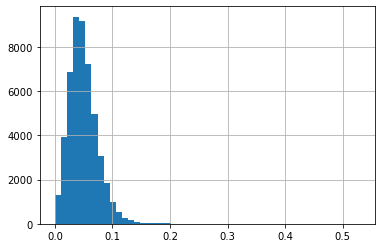

In [11]:
result_pre['score'].hist(bins = 50)


In [11]:
# change distance value <5.0 to 5.0
result_pre.loc[result_pre['score'] < 2.014024e-05, 'score'] = 2.014024e-05

In [12]:
result_pre.groupby('score').count().head(20)

,query_id,reference_id
score,,
0.000020,2,2
0.000172,1,1
0.000186,1,1
0.000227,1,1
0.000230,1,1
0.000279,1,1
0.000290,1,1
0.000414,1,1
0.000487,1,1


In [12]:
result_pre.score = 0.03 / result_pre.score

In [13]:
result_pre.set_index('query_id').to_csv("triplet_loss//result_final_semihard48.csv")

In [6]:
result = pd.read_csv("triplet_loss//result_final_semihard48.csv")
result

,query_id,reference_id,score
0,Q00000,R001780,0.037960
1,Q00001,R542951,0.044301
2,Q00002,R795222,0.044919
3,Q00003,R115109,0.079307
4,Q00004,R840634,0.333681
...,...,...,...
49995,Q49995,R493332,0.040336
49996,Q49996,R003117,0.076094
49997,Q49997,R831298,0.248206
49998,Q49998,R078831,0.062240


In [7]:
result['score'] = result['score'].multiply(10)

In [8]:
# use existing script to evaluate
from eval_metrics_script.eval_metrics import evaluate_metrics
import json

result = pd.read_csv("triplet_loss//result_final_semihard48.csv")
gt_df = pd.read_csv(ground_truth_csv)
ap, rp90 = evaluate_metrics(result, gt_df)

print(json.dumps(
            {
                "average_precision": ap,
                "recall_p90": rp90,
            },
            indent=2,
        )
    )

{
  "average_precision": 0.0008578499079724567,
  "recall_p90": 0.0
}
